In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

In [3]:
train_df = pd.read_csv("train.csv")
print('Train data shape: {}'.format(train_df.shape))
train_df.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
train_df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [5]:
#to remove such outliers, we limit our maximum trip duration to 3 standard deviations more than the mean.


m = np.mean(train_df['trip_duration'])
sd = np.std(train_df['trip_duration'])
train_df = train_df[train_df['trip_duration'] <= m + 3*sd]
train_df = train_df[train_df['trip_duration'] >= m - 2*sd]
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.456571e+06,1.456571e+06,1.456571e+06,1.456571e+06,1.456571e+06,1.456571e+06,1.456571e+06
mean,1.534295e+00,1.663944e+00,-7.397349e+01,4.075093e+01,-7.397342e+01,4.075180e+01,8.371182e+02
std,4.988227e-01,1.313618e+00,7.091271e-02,3.286613e-02,7.067458e-02,3.588825e-02,6.613656e+02
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073589e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075453e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396302e+01,4.076981e+01,1.073000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.590000e+04


In [6]:
test_df = pd.read_csv("test.csv")

We modify the pickup_datetime, pickup_date, and dropoff_datetime (not present in test set) columns according to pandas dataframes so that we may use them further.

In [7]:
train_df['pickup_datetime'] = pd.to_datetime(train_df.pickup_datetime)
test_df['pickup_datetime'] = pd.to_datetime(test_df.pickup_datetime)
train_df.loc[:, 'pickup_date'] = train_df['pickup_datetime'].dt.date
test_df.loc[:, 'pickup_date'] = test_df['pickup_datetime'].dt.date
train_df['dropoff_datetime'] = pd.to_datetime(train_df.dropoff_datetime)

we extract the Month, Day of Month, Day of week, and hour in seperate columns as these can't really be used together.



In [8]:
#Extracting month
train_df['Month'] = train_df['pickup_datetime'].dt.month
test_df['Month'] = test_df['pickup_datetime'].dt.month

#Extracting day of month
train_df['DayofMonth'] = train_df['pickup_datetime'].dt.day
test_df['DayofMonth'] = test_df['pickup_datetime'].dt.day

#Extracting day of week
train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek
test_df['dayofweek'] = test_df['pickup_datetime'].dt.dayofweek

#Extracting hour of the day
train_df['Hour'] = train_df['pickup_datetime'].dt.hour
test_df['Hour'] = test_df['pickup_datetime'].dt.hour

In [9]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,Month,DayofMonth,dayofweek,Hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,3,14,0,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,6,12,6,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,1,19,1,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,4,6,2,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,3,26,5,13


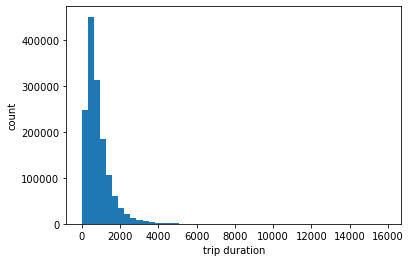

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.hist(train_df['trip_duration'].values, bins=50)
plt.xlabel('trip duration')
plt.ylabel('count')
plt.show()

Text(0.5, 1.0, 'Dropoff Longitude vs Trip Duration')

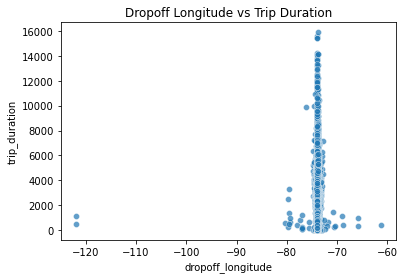

In [11]:
sns.scatterplot(data=train_df,
               x='dropoff_longitude',
               y='trip_duration',
               alpha=0.7);
plt.title('Dropoff Longitude vs Trip Duration')

<AxesSubplot:xlabel='store_and_fwd_flag', ylabel='trip_duration'>

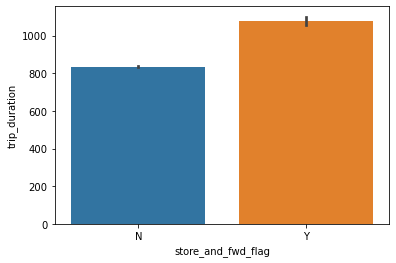

In [12]:
sns.barplot(x='store_and_fwd_flag', y='trip_duration', data = train_df)


<AxesSubplot:xlabel='passenger_count', ylabel='trip_duration'>

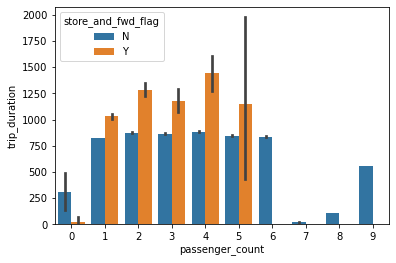

In [13]:
sns.barplot(x='passenger_count', y='trip_duration', hue='store_and_fwd_flag', data = train_df)

we can't use the pickup and dropoff latitudes and longitudes as they are. We need to make some changes to them. Preferably, we could calculate distances.

In [14]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [15]:
train_df.loc[:, 'distance_haversine'] = haversine_array(train_df['pickup_latitude'].values, 
                                                        train_df['pickup_longitude'].values, 
                                                        train_df['dropoff_latitude'].values, 
                                                        train_df['dropoff_longitude'].values)
test_df.loc[:, 'distance_haversine'] = haversine_array(test_df['pickup_latitude'].values, 
                                                       test_df['pickup_longitude'].values, 
                                                       test_df['dropoff_latitude'].values, 
                                                       test_df['dropoff_longitude'].values)    
    
train_df.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train_df['pickup_latitude'].values, 
                                                                        train_df['pickup_longitude'].values, 
                                                                        train_df['dropoff_latitude'].values, 
                                                                        train_df['dropoff_longitude'].values)
test_df.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(test_df['pickup_latitude'].values, 
                                                                       test_df['pickup_longitude'].values, 
                                                                       test_df['dropoff_latitude'].values, 
                                                                       test_df['dropoff_longitude'].values)

train_df.loc[:, 'direction'] = bearing_array(train_df['pickup_latitude'].values, 
                                             train_df['pickup_longitude'].values, 
                                             train_df['dropoff_latitude'].values, 
                                             train_df['dropoff_longitude'].values)
test_df.loc[:, 'direction'] = bearing_array(test_df['pickup_latitude'].values, 
                                            test_df['pickup_longitude'].values, 
                                            test_df['dropoff_latitude'].values, 
                                            test_df['dropoff_longitude'].values)

In [16]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,Month,DayofMonth,dayofweek,Hour,distance_haversine,distance_dummy_manhattan,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,3,14,0,17,1.498521,1.735433,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,6,12,6,0,1.805507,2.430506,-117.153768
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,1,19,1,11,6.385098,8.203575,-159.680165
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,4,6,2,19,1.485498,1.661331,-172.737700
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,3,26,5,13,1.188588,1.199457,179.473585


In [17]:
numerical_cols = ['distance_haversine', 'distance_dummy_manhattan', 'direction' ]
categorical_cols = ['vendor_id', 'store_and_fwd_flag', 'passenger_count', 'Month', 'DayofMonth', 'dayofweek', 'Hour' ]


## Imputing and Scaling Numerical Data 

In [18]:
train_df[numerical_cols].isna().sum()

distance_haversine          0
distance_dummy_manhattan    0
direction                   0
dtype: int64

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler().fit(train_df[numerical_cols])
train_df[numerical_cols] = scaler.transform(train_df[numerical_cols])
test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])

In [20]:
vendor_train = pd.get_dummies(train_df['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test_df['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train_df['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test_df['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train_df['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test_df['store_and_fwd_flag'], prefix='sf', prefix_sep='_')

month_train = pd.get_dummies(train_df['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test_df['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train_df['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test_df['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train_df['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test_df['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train_df['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test_df['dayofweek'], prefix='dow', prefix_sep='_')

In [21]:
train_df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,Month,DayofMonth,dayofweek,Hour,distance_haversine,distance_dummy_manhattan,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,3,14,0,17,0.001208,0.001316,0.777690
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,6,12,6,0,0.001455,0.001843,0.174556
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,1,19,1,11,0.005146,0.006222,0.056425
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,4,6,2,19,0.001197,0.001260,0.020153
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,3,26,5,13,0.000958,0.000910,0.998538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,4,8,4,13,0.000987,0.001263,0.169263
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,1,10,6,7,0.004875,0.006112,0.570386
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,4,22,4,6,0.006306,0.008074,0.081124
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,1,5,1,15,0.000880,0.001154,0.597307


In [22]:
train_df = train_df.drop(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 
                          'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_date', 'Month', 
                          'DayofMonth', 'dayofweek', 'Hour'], axis = 1)
test_df = test_df.drop(['id', 'vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 
                          'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_date', 'Month', 
                          'DayofMonth', 'dayofweek', 'Hour'], axis = 1)

In [23]:
train_df.head()

,trip_duration,distance_haversine,distance_dummy_manhattan,direction
0,455,0.001208,0.001316,0.777690
1,663,0.001455,0.001843,0.174556
2,2124,0.005146,0.006222,0.056425
3,429,0.001197,0.001260,0.020153
4,435,0.000958,0.000910,0.998538


In [24]:
test_df.head()

,distance_haversine,distance_dummy_manhattan,direction
0,0.002213,0.002210,0.490003
1,0.002224,0.002355,0.978552
2,0.001053,0.001400,0.870348
3,0.004246,0.005433,0.080657
4,0.000774,0.001027,0.861832


In [25]:
train2_df = pd.concat([train_df,
                      vendor_train,
                      passenger_count_train,
                      store_and_fwd_flag_train,
                      month_train,
                      dom_train,
                      hour_train,
                      dow_train
                      ], axis = 1)
train2_df

,trip_duration,distance_haversine,distance_dummy_manhattan,direction,vi_1,vi_2,pc_0,pc_1,pc_2,pc_3,...,h_21,h_22,h_23,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,455,0.001208,0.001316,0.777690,False,True,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
1,663,0.001455,0.001843,0.174556,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
2,2124,0.005146,0.006222,0.056425,False,True,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
3,429,0.001197,0.001260,0.020153,False,True,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
4,435,0.000958,0.000910,0.998538,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,778,0.000987,0.001263,0.169263,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1458640,655,0.004875,0.006112,0.570386,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
1458641,764,0.006306,0.008074,0.081124,False,True,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1458642,373,0.000880,0.001154,0.597307,True,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False


In [26]:
test2_df = pd.concat([test_df,
                      vendor_test,
                      passenger_count_test,
                      store_and_fwd_flag_test,
                      month_test,
                      dom_test,
                      hour_test,
                      dow_test
                      ], axis = 1)
test2_df

,distance_haversine,distance_dummy_manhattan,direction,vi_1,vi_2,pc_0,pc_1,pc_2,pc_3,pc_4,...,h_21,h_22,h_23,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,0.002213,0.002210,0.490003,True,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
1,0.002224,0.002355,0.978552,True,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
2,0.001053,0.001400,0.870348,True,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
3,0.004246,0.005433,0.080657,False,True,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
4,0.000774,0.001027,0.861832,True,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625129,0.000780,0.000861,0.530852,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
625130,0.004993,0.006646,0.627822,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
625131,0.006571,0.007056,0.774313,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
625132,0.016424,0.021156,0.584089,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [27]:
test2_df['pc_7'] = 0
test2_df['pc_8'] = 0
test2_df

,distance_haversine,distance_dummy_manhattan,direction,vi_1,vi_2,pc_0,pc_1,pc_2,pc_3,pc_4,...,h_23,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,pc_7,pc_8
0,0.002213,0.002210,0.490003,True,False,False,True,False,False,False,...,True,False,False,False,True,False,False,False,0,0
1,0.002224,0.002355,0.978552,True,False,False,True,False,False,False,...,True,False,False,False,True,False,False,False,0,0
2,0.001053,0.001400,0.870348,True,False,False,True,False,False,False,...,True,False,False,False,True,False,False,False,0,0
3,0.004246,0.005433,0.080657,False,True,False,True,False,False,False,...,True,False,False,False,True,False,False,False,0,0
4,0.000774,0.001027,0.861832,True,False,False,True,False,False,False,...,True,False,False,False,True,False,False,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625129,0.000780,0.000861,0.530852,True,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,0,0
625130,0.004993,0.006646,0.627822,True,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,0,0
625131,0.006571,0.007056,0.774313,True,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,0,0
625132,0.016424,0.021156,0.584089,True,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,0,0


In [28]:
col = list(test2_df.columns)
col2 = col[0:12] + col[83:85] + col[12:83]
len(col2)

85

In [29]:
test_inputs = test2_df[col2]
test_inputs

,distance_haversine,distance_dummy_manhattan,direction,vi_1,vi_2,pc_0,pc_1,pc_2,pc_3,pc_4,...,h_21,h_22,h_23,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,0.002213,0.002210,0.490003,True,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
1,0.002224,0.002355,0.978552,True,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
2,0.001053,0.001400,0.870348,True,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
3,0.004246,0.005433,0.080657,False,True,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
4,0.000774,0.001027,0.861832,True,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625129,0.000780,0.000861,0.530852,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
625130,0.004993,0.006646,0.627822,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
625131,0.006571,0.007056,0.774313,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
625132,0.016424,0.021156,0.584089,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [30]:
from sklearn.model_selection import train_test_split
train_final, val_final = train_test_split(train2_df[0:100000], test_size=0.2, random_state=42)

In [31]:
train_inputs = train_final.drop(['trip_duration'], axis=1)
train_targets = train_final["trip_duration"]
val_inputs = val_final.drop(['trip_duration'], axis=1)
val_targets = val_final["trip_duration"]

In [32]:
train_inputs.shape, train_targets.shape

((80000, 85), (80000,))

# Training the Model
## RandomForest Model

In [33]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs = -1, random_state = 42)
model.fit(train_inputs, train_targets)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [34]:
model.score(val_inputs, val_targets), model.score(train_inputs, train_targets)

(0.6997741114737763, 0.9598378307177351)

In [35]:
def random_guess(n):
    return np.random.randint(0, 15900, size=n)

In [36]:
val_targets.describe()

count    20000.000000
mean       836.050300
std        662.573033
min          2.000000
25%        392.000000
50%        661.000000
75%       1075.000000
max      14243.000000
Name: trip_duration, dtype: float64

In [37]:
from sklearn.metrics import mean_squared_error
train_preds = model.predict(train_inputs)
train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
train_rmse

131.9616754218103

In [38]:
random_rmse = mean_squared_error(val_targets, random_guess(20000), squared=False)
random_rmse

8469.299017297713

In [39]:
val_preds = model.predict(val_inputs)
val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
val_rmse

363.0337215036498

In [40]:
def try_params(**params):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    return model.score(train_inputs, train_targets), model.score(val_inputs, val_targets)

In [41]:
try_params(n_estimators = 200, max_leaf_nodes = 2**20)

(0.9606892697611796, 0.7016797060375914)

In [42]:
try_params(n_estimators = 200, max_leaf_nodes = 2**20, max_depth = 20)

(0.893574775339675, 0.6992785442047237)

In [43]:
try_params(n_estimators = 500)

(0.9611607693505916, 0.7020819827128979)

In [44]:
test_preds = model.predict(test_inputs)